# **PROYECTO IA: Forecasting para demanda de productos en empresa Manufacturera**

![Imagen1](https://www.insidesales.com/wp-content/uploads/2021/01/HEADER-2.jpg)




---



## **Contexto**

El conjunto de datos contiene ***la demanda histórica de productos de una empresa manufacturera*** con presencia en todo el mundo. La empresa ofrece miles de productos dentro de docenas de categorías de productos.

Se pretende lograr pronósticos para cada producto en diferentes centrales con una precisión razonable para la demanda mensual del mes siguiente. Esto sería beneficioso para la empresa.

## **Objetivos**

-Aprender el uso y la aplicación de distintos modelos de machine learning para el forecasting en series de tiempo.

-Adaptación de los modelos clásicos de regresión de  machine learning para su uso en el forecasting mediante el uso de lags.

-Aprendizaje del uso de modelos basados en redes neuronales para el forecasting.

-Despliegue del modelo de machine learning para su posterior uso.


## **Fuente de datos**
https://www.kaggle.com/datasets/felixzhao/productdemandforecasting



---



## **Metadata**

Nombre dataset: **Historical Product Demand.csv - CSV**

Fuente: **Kaggle.com**

Columnas(5): **Product_Code, Warehouse, Product_Category, Date,
       Order_Demand**

Total filas: **1.048.575**

Año publicacion: **2017**

Autor: Felixzhao

## **Metodología** (4 etapas)

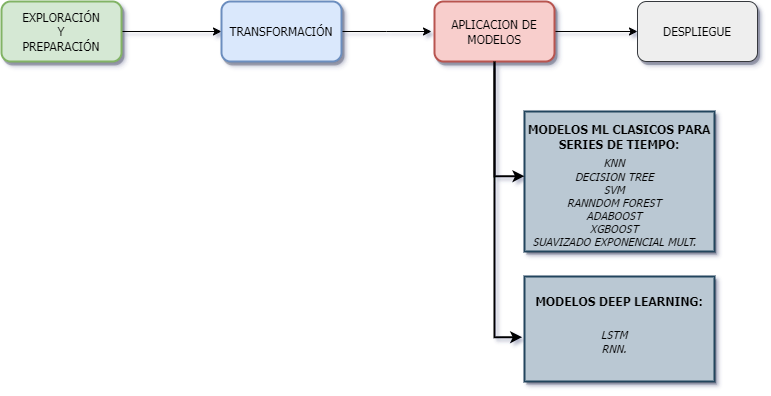



---



# **Exploración y Preparación** (etapa 1)

## 0. Carga de dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/MyDrive/Proyecto/Grupo 5/"

Mounted at /content/drive


In [ ]:
import pandas as pd
#path="/content/sample_data/"
df_raw = pd.read_csv(path+'datos/Historical Product Demand.csv')
df=df_raw.copy()

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


### 0.1. Removing nulls

In [ ]:
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031437 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Product_Code      1031437 non-null  object 
 1   Warehouse         1031437 non-null  object 
 2   Product_Category  1031437 non-null  object 
 3   Date              1031437 non-null  object 
 4   Order_Demand      1031437 non-null  float64
dtypes: float64(1), object(4)
memory usage: 47.2+ MB


In [ ]:
df.nunique()

,0
Product_Code,2160
Warehouse,4
Product_Category,33
Date,1727
Order_Demand,3283


In [ ]:
import matplotlib.pyplot as plt
def plot_col(df,name):
  city_counts = df[name].value_counts()

  # Create a bar plot
  city_counts.plot(kind='bar')
  plt.xlabel(name)
  plt.ylabel('Number of Rows')
  plt.show()

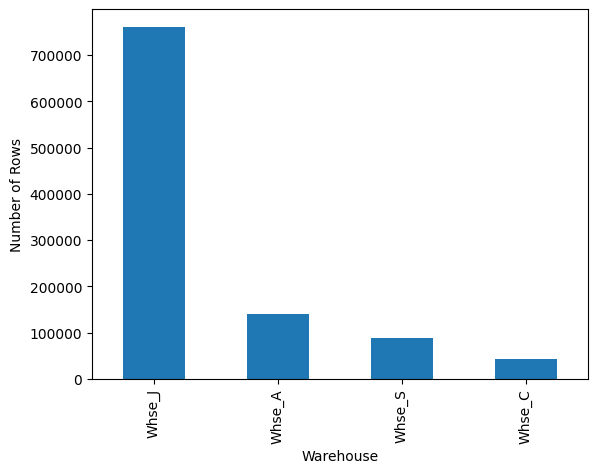

In [ ]:
plot_col(df,"Warehouse")

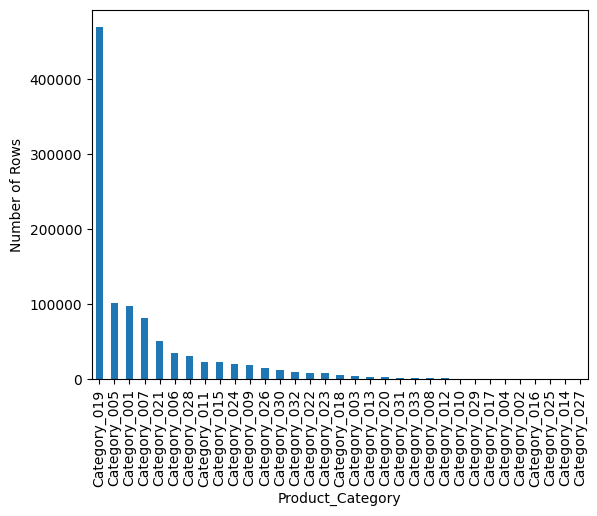

In [ ]:
plot_col(df,"Product_Category")

### 0.2. Ajuste de Tipado y Filtrado de datos

In [ ]:
df_filtered = df.copy()
df_filtered = df_filtered.drop(columns=['Warehouse','Product_Code','Product_Code'])
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered['Order_Demand'] = df_filtered['Order_Demand'].astype(float)
df_filtered = df_filtered[(df_filtered['Date'] >= '2012-01-02') & (df_filtered['Date'] <= '2016-12-31')]
df_filtered=df_filtered.reset_index(drop=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030783 entries, 0 to 1030782
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Category  1030783 non-null  object        
 1   Date              1030783 non-null  datetime64[ns]
 2   Order_Demand      1030783 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.6+ MB


.

# **Transformación de los datos** (etapa 2)

### 0.3. Transforming dates to weekly and monthly

In [ ]:
# Semanas
df_filtered['start_of_week']  = df_filtered['Date'] - pd.to_timedelta(df_filtered['Date'].dt.weekday, unit='D')

# Mes
df_filtered['start_of_month'] = df_filtered['Date'].dt.to_period('M').dt.to_timestamp()

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030783 entries, 0 to 1030782
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Category  1030783 non-null  object        
 1   Date              1030783 non-null  datetime64[ns]
 2   Order_Demand      1030783 non-null  float64       
 3   start_of_week     1030783 non-null  datetime64[ns]
 4   start_of_month    1030783 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(1)
memory usage: 39.3+ MB


### 0.4. Pivoting dataframe by months and weeks

In [ ]:
pivot_df_weekly_real = df_filtered.pivot_table(
    index='start_of_week',
    columns='Product_Category',
    values='Order_Demand',
    aggfunc='sum',
    #fill_value=0  # Fill missing values with 0 (or another appropriate value)
)

pivot_df_monthly_real = df_filtered.pivot_table(
    index='start_of_month',
    columns='Product_Category',
    values='Order_Demand',
    aggfunc='sum',
    #fill_value=0  # Fill missing values with 0 (or another appropriate value)
)

In [ ]:
pivot_df_weekly_real = pivot_df_weekly_real.fillna(0)

pivot_df_monthly_real = pivot_df_monthly_real.fillna(0)

### 0.5. Plotting data

In [ ]:
def plot_pivot_col(df):
  plt.figure(figsize=(10, 6))
  for column in df.columns:
      plt.plot(df.index,df[column], label=column)

  plt.xlabel('Start of Week')
  plt.ylabel('Order Demand')
  plt.title('Order Demand Over Time by Product Category')
  plt.legend(title='Product Category')
  plt.grid(True)
  plt.show()

In [ ]:
def new_col_sum(df):
  df_new= df.copy()
  for i,column in enumerate(df_new.columns):
    if i==0: df_new["sum"]=0
    df_new["sum"]=df_new[column]+df_new["sum"]
    df_new= df_new.drop(columns=[column])
  return df_new


In [ ]:
df_weekly_total=new_col_sum(pivot_df_weekly_real)
df_monthly_total=new_col_sum(pivot_df_monthly_real)

In [ ]:
df_weekly_total=df_weekly_total.resample('W').mean()
df_monthly_total=df_monthly_total.resample('M').mean()

<ipython-input-16-0503536d0e51>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_total=df_monthly_total.resample('M').mean()


In [ ]:
df_weekly_total

Product_Category,sum
start_of_week,
2012-01-08,17925254.0
2012-01-15,16518425.0
2012-01-22,16412380.0
2012-01-29,13351238.0
2012-02-05,22337324.0
...,...
2016-12-04,26451676.0
2016-12-11,21296025.0
2016-12-18,19918612.0


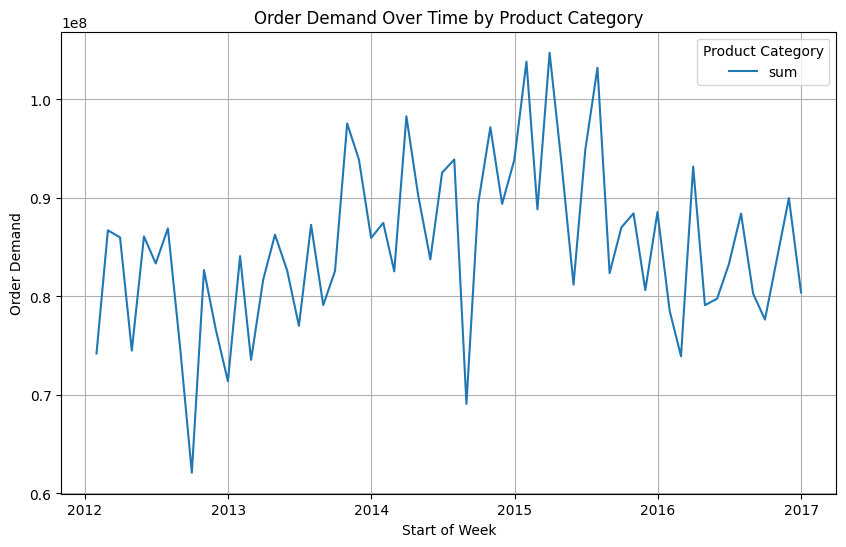

In [ ]:
plot_pivot_col(df_monthly_total)

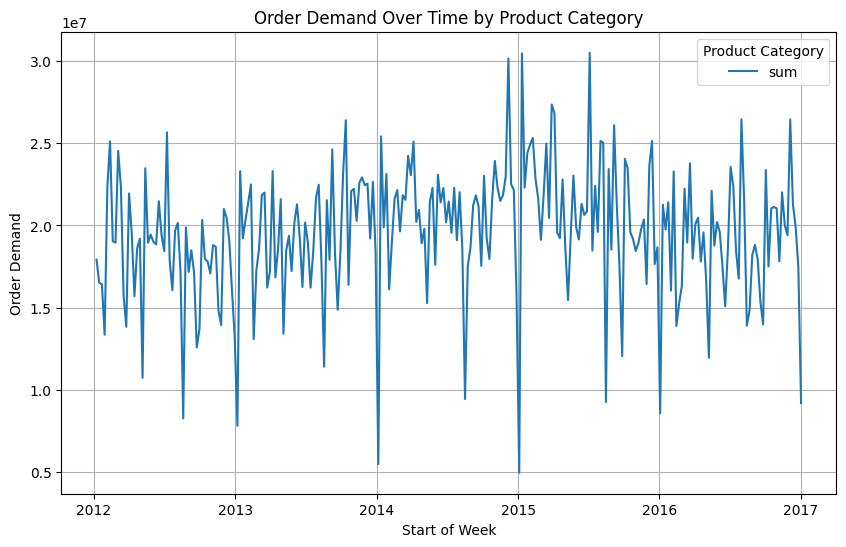

In [ ]:
plot_pivot_col(df_weekly_total)

.

# **Aplicación de los modelos** (etapa 3)

### 1.1. Create training and test

In [ ]:
import math
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV   # crossValidation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, TimeDistributed, Flatten, Dropout

from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
def create_lag_features(df, lags):
    df_X = pd.DataFrame()
    df_Y = pd.DataFrame()
    df_Y = df.iloc[lags:]
    for lag in range(1, lags+1):
        df_X[f'{"sum"}_lag_{lag}'] = df.shift(lag)
    df_X.dropna(inplace=True)
    return df_X, df_Y


In [ ]:
scaler = MinMaxScaler()  # Normalizar los datos

data_monthly_scaled = scaler.fit_transform(df_monthly_total)
data_weekly_scaled = scaler.fit_transform(df_weekly_total)


df_monthly_scaled = pd.DataFrame(data_monthly_scaled, index=df_monthly_total.index, columns=df_monthly_total.columns)
df_weekly_scaled  = pd.DataFrame(data_weekly_scaled,  index=df_weekly_total.index,  columns=df_weekly_total.columns)


In [ ]:
X_m,Y_m = create_lag_features(df_monthly_scaled, lags=12)
X_w,Y_w = create_lag_features(df_weekly_scaled, lags=52)


In [ ]:
#----------------------------------------------------------
### Create training and test MONTHLY
X_train_m=X_m[:X_m.shape[0]-12]
Y_train_m=Y_m[:Y_m.shape[0]-12]

X_test_m=X_m[X_m.shape[0]-12:]
Y_test_m=Y_m[Y_m.shape[0]-12:]



### Create training and test WEEKLY
X_train_w=X_w[:X_w.shape[0]-52]
Y_train_w=Y_w[:Y_w.shape[0]-52]

X_test_w=X_w[X_w.shape[0]-52:]
Y_test_w=Y_w[Y_w.shape[0]-52:]

Y_train_w_inv = df_weekly_total[52:-52]
Y_train_w_inv_tot = df_weekly_total[:-52]
Y_test_w_inv  = df_weekly_total[-52:]



### 1.2. Function to Plot

In [ ]:
def graph(Y_train,Y_test,Y_pred):
  # Plotting
  plt.figure(figsize=(20, 7))

  # Plotting y_train
  plt.plot(Y_train.index, Y_train, label='Train', color='blue', linewidth=2)

  # Plotting y_test
  plt.plot(Y_test.index, Y_test, label='Test', color='green', linewidth=2)

  # Plotting y_pred (predicted values)
  plt.plot(Y_test.index, Y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

  # Adding title and labels
  plt.title('Sales Prediction')
  plt.xlabel('Date')
  plt.ylabel('Sales')
  plt.legend()

  # Show plot
  plt.show()




---



## 2. Models

### 2.1. Creando modelo 1: K-vecinos

In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor

# Setting up the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initializing the model
knn = KNeighborsRegressor()

# Grid Search
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_w, Y_train_w)

# Best parameters and model
print("Best Parameters for KNN:", grid_search_knn.best_params_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
CPU times: user 263 ms, sys: 63.9 ms, total: 327 ms
Wall time: 2.54 s


In [ ]:
# Predictions
best_knn = grid_search_knn.best_estimator_
pred_knn = best_knn.predict(X_test_w)

MSE for KNN: 3127955.2321376977
R2 for KNN: 0.15191830214128643
MAPE for KNN: 0.15068627218385094


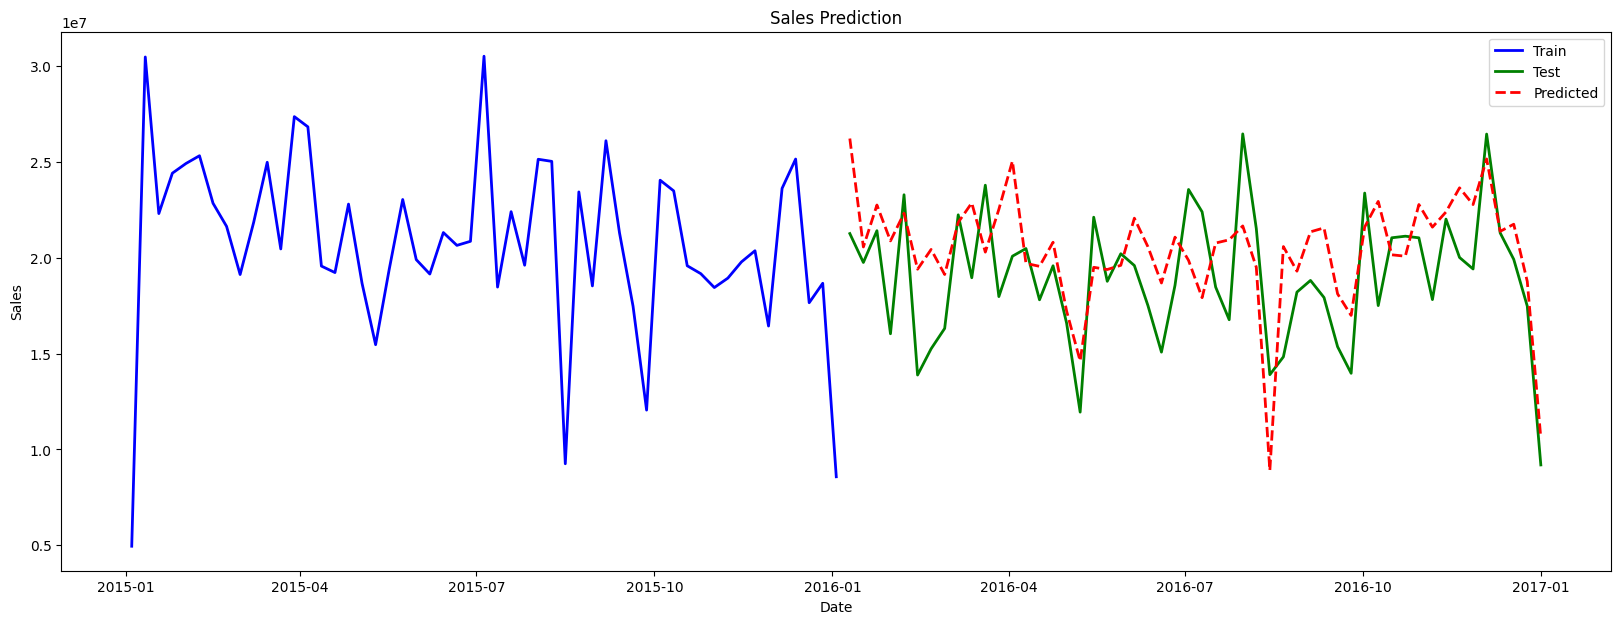

In [ ]:
mse_knn = metrics.mean_squared_error(Y_test_w_inv, scaler.inverse_transform(pred_knn))
r2_knn =  metrics.r2_score(Y_test_w_inv, scaler.inverse_transform(pred_knn))
mape_knn =  metrics.mean_absolute_percentage_error(Y_test_w_inv, scaler.inverse_transform(pred_knn))
print("MSE for KNN:", math.sqrt(mse_knn))
print("R2 for KNN:", r2_knn)
print("MAPE for KNN:", mape_knn)
graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(pred_knn))

###2.2. Creando modelo 2: Decision Tree

In [ ]:
%%time
from sklearn.tree import  DecisionTreeRegressor
depth_grid = np.arange(1,22,5)
min_samples_leaf_grid = np.arange(2,23,5) #
max_leaf_nodes_grid = np.arange(23,54,5)#
parameters_dt = {'max_depth':depth_grid, 'min_samples_leaf':min_samples_leaf_grid, 'max_leaf_nodes':max_leaf_nodes_grid}

gridCV_dt = GridSearchCV(DecisionTreeRegressor(random_state = 12345), parameters_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gridCV_dt.fit(X_train_w, Y_train_w)
#-----------
print("Best Parameters for Decision Tree:", gridCV_dt.best_params_)

Best Parameters for Decision Tree: {'max_depth': 1, 'max_leaf_nodes': 23, 'min_samples_leaf': 2}
CPU times: user 638 ms, sys: 19.2 ms, total: 657 ms
Wall time: 10.2 s


In [ ]:
best_dt = gridCV_dt.best_estimator_
pred_dt = best_dt.predict(X_test_w)

MSE for Decision Tree: 3329049.3140242547
R2 for Decision Tree 0.03936790925442568
MAPE for Decision Tree 0.15568016783946292


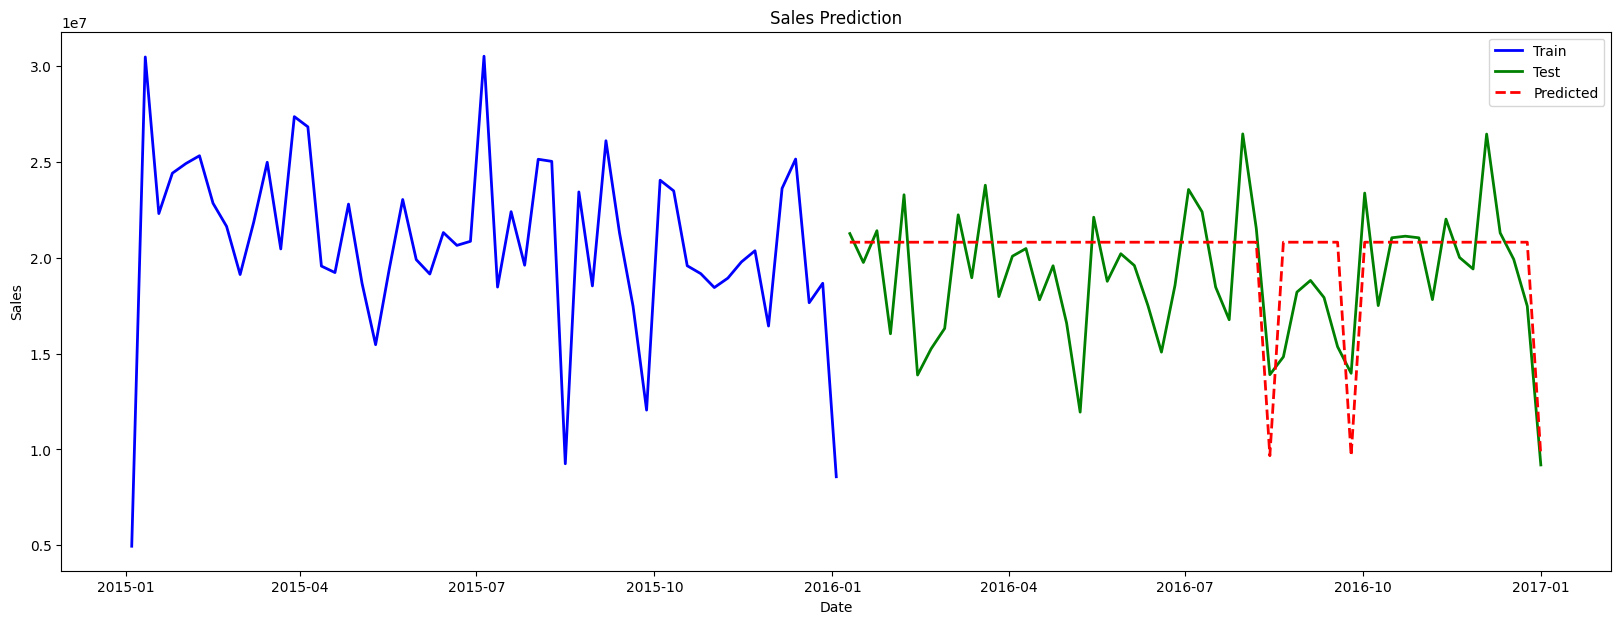

In [ ]:
mse_dt = metrics.mean_squared_error(Y_test_w_inv, scaler.inverse_transform(pred_dt.reshape(-1, 1)))
r2_dt =  metrics.r2_score(Y_test_w_inv, scaler.inverse_transform(pred_dt.reshape(-1, 1)))
mape_dt =  metrics.mean_absolute_percentage_error(Y_test_w_inv, scaler.inverse_transform(pred_dt.reshape(-1, 1)))
print("MSE for Decision Tree:", math.sqrt(mse_dt))
print("R2 for Decision Tree", r2_dt)
print("MAPE for Decision Tree", mape_dt)
graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(pred_dt.reshape(-1, 1)))

###2.3. Creando modelo 3: SVM

In [ ]:
%%time
from sklearn.svm import SVR

param_grid_svm = {
    'C': [1],
    'gamma': ['scale', 'auto'],
    'degree': [2,3],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initializing the model
svm = SVR()

# Grid Search
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train_w, Y_train_w)

# Best parameters and model
print("Best Parameters for SVM:", grid_search_svm.best_params_)

Best Parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
CPU times: user 92.9 ms, sys: 4.26 ms, total: 97.1 ms
Wall time: 671 ms


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
best_svm = grid_search_svm.best_estimator_
# Predictions
pred_svm = best_svm.predict(X_test_w)

MSE for SVM: 3068109.1481214794
R2 for SVM 0.18405996142688397
MAPE for SVM 0.14906750199241697


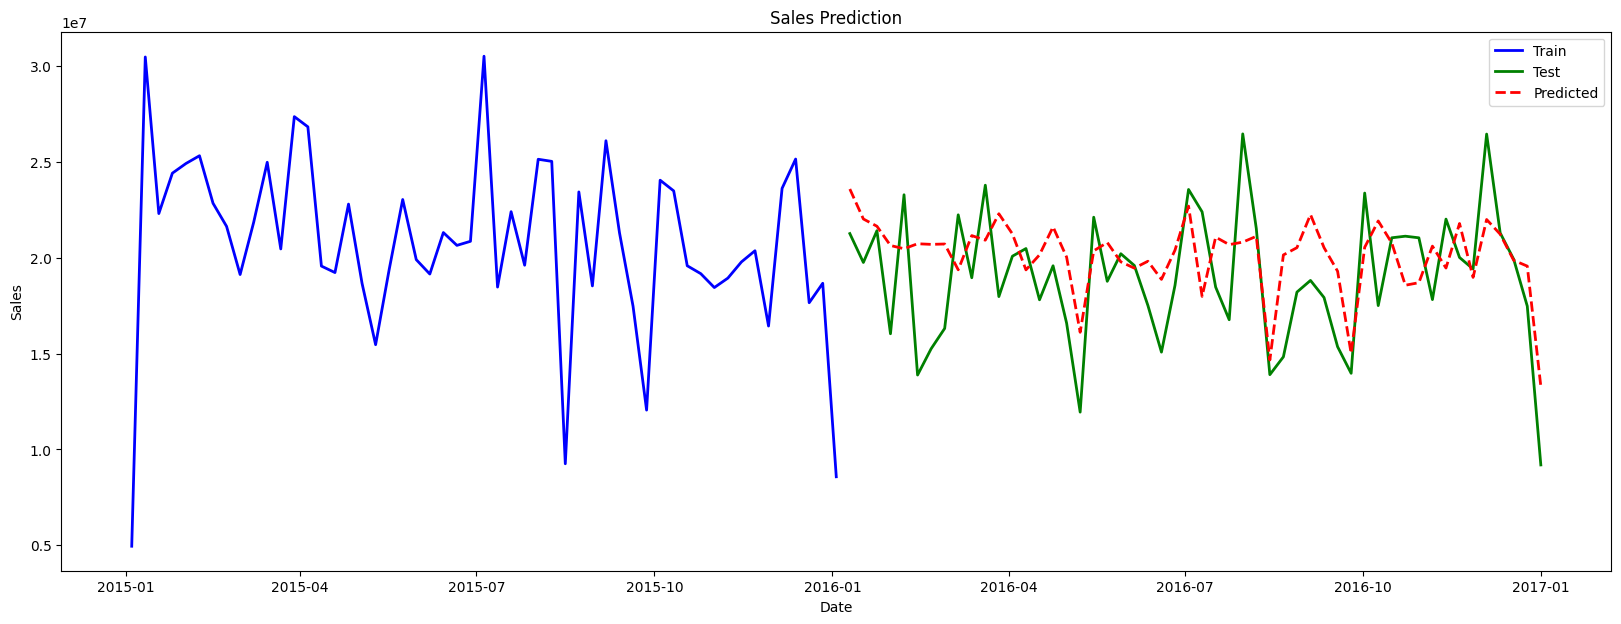

In [ ]:
mse_svm = metrics.mean_squared_error(Y_test_w_inv, scaler.inverse_transform(pred_svm.reshape(-1, 1)))
r2_svm =  metrics.r2_score(Y_test_w_inv, scaler.inverse_transform(pred_svm.reshape(-1, 1)))
mape_svm =  metrics.mean_absolute_percentage_error(Y_test_w_inv, scaler.inverse_transform(pred_svm.reshape(-1, 1)))
print("MSE for SVM:", math.sqrt(mse_svm))
print("R2 for SVM", r2_svm)
print("MAPE for SVM", mape_svm)
graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(pred_svm.reshape(-1, 1)))#.reshape(-1, 1)

###2.4. Creando modelo 4: Random Forest

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Setting up the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'bootstrap': [True, False]
}

# Initializing the model
rf = RandomForestRegressor(parameters_dt)

# Grid Search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_w, Y_train_w)

# Best parameters and model
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters for Random Forest: {'bootstrap': True, 'n_estimators': 300}
CPU times: user 2.15 s, sys: 38.2 ms, total: 2.19 s
Wall time: 32.4 s


In [ ]:
best_rf = grid_search_rf.best_estimator_

# Predictions
pred_rf = best_rf.predict(X_test_w)

MSE for Random Forest: 2967610.1281195316
R2 for Random Forest: 0.23663837675692456
MAPE for Random Forest: 0.13843138256446347


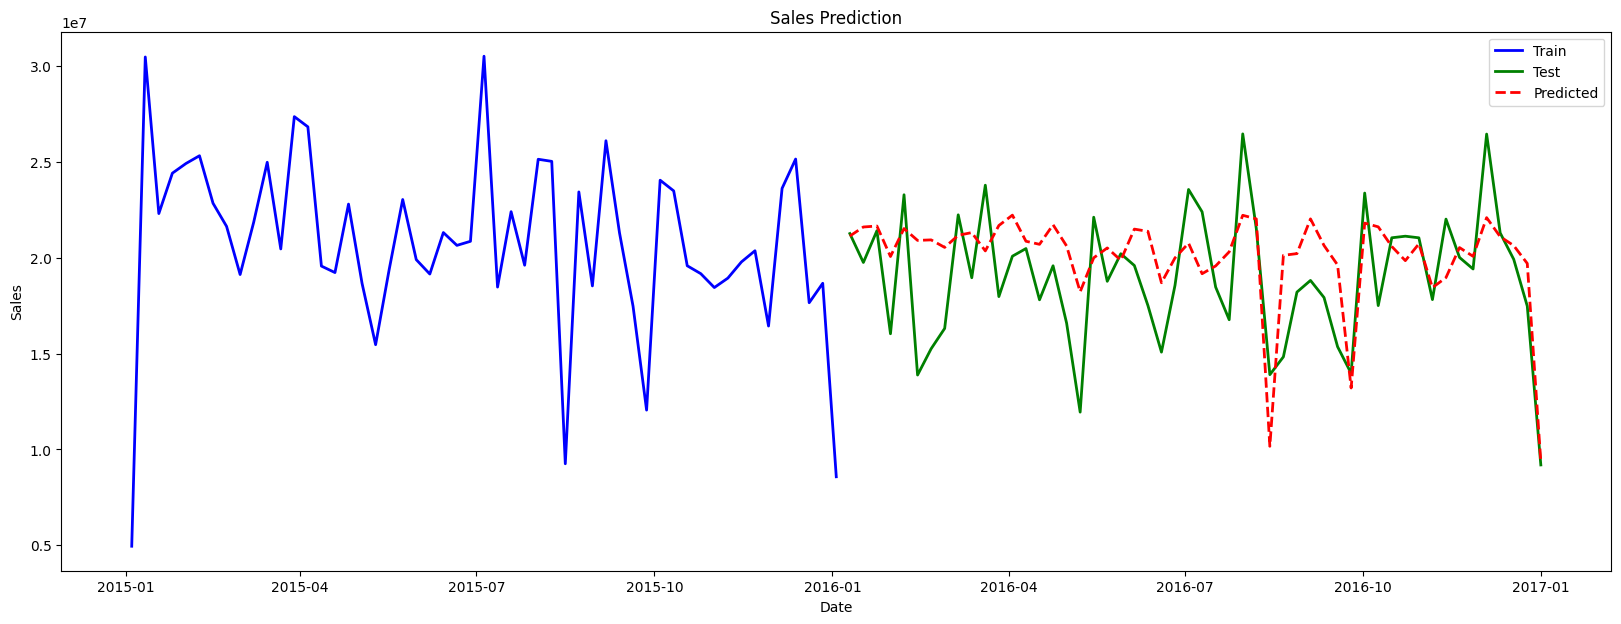

In [ ]:
mse_rf = metrics.mean_squared_error(Y_test_w_inv, scaler.inverse_transform(pred_rf.reshape(-1, 1)))
r2_rf =  metrics.r2_score(Y_test_w_inv, scaler.inverse_transform(pred_rf.reshape(-1, 1)))
mape_rf =  metrics.mean_absolute_percentage_error(Y_test_w_inv, scaler.inverse_transform(pred_rf.reshape(-1, 1)))
print("MSE for Random Forest:", math.sqrt(mse_rf))
print("R2 for Random Forest:", r2_rf )
print("MAPE for Random Forest:", mape_rf )


graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(pred_rf.reshape(-1, 1)))

###2.5. Creando modelo 5: AdaBoost

In [ ]:
%%time
from sklearn.ensemble import AdaBoostRegressor

# Setting up the parameter grid
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Initializing the model
ab = AdaBoostRegressor(best_knn)

# Grid Search
grid_search_ab = GridSearchCV(estimator=ab, param_grid=param_grid_ab, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ab.fit(X_train_w, Y_train_w)

# Best parameters and model
print("Best Parameters for AdaBoost:", grid_search_ab.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 100}
CPU times: user 390 ms, sys: 15.8 ms, total: 406 ms
Wall time: 8.27 s


In [ ]:
best_ab = grid_search_ab.best_estimator_

# Predictions
pred_ab = best_ab.predict(X_test_w)

MSE for AdaBoost: 3051786.05261265
R2 for AdaBoost: 0.19271886972821384
MAPE for AdaBoost: 0.14614527402698405


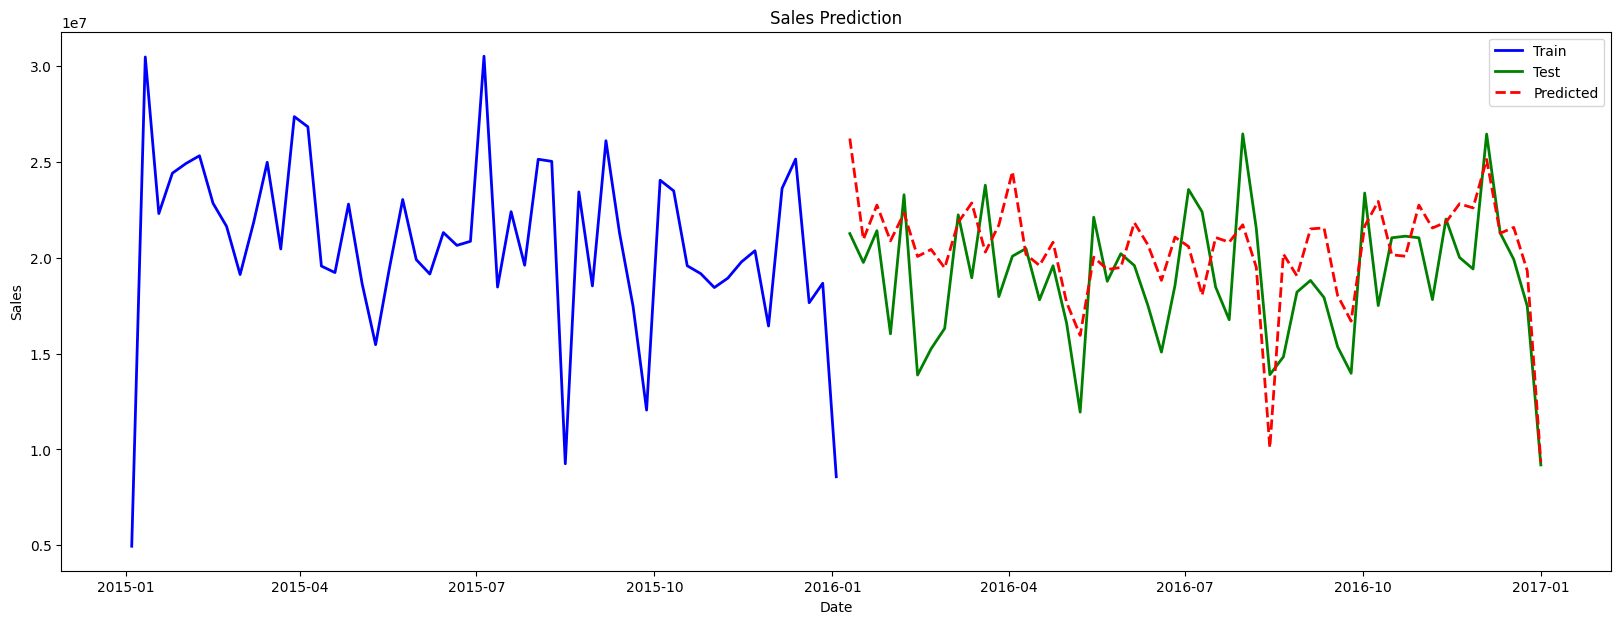

In [ ]:
mse_ab = metrics.mean_squared_error(Y_test_w_inv, scaler.inverse_transform(pred_ab.reshape(-1, 1)))
r2_ab =  metrics.r2_score(Y_test_w_inv, scaler.inverse_transform(pred_ab.reshape(-1, 1)))
mape_ab =  metrics.mean_absolute_percentage_error(Y_test_w_inv, scaler.inverse_transform(pred_ab.reshape(-1, 1)))

print("MSE for AdaBoost:", math.sqrt(mse_ab))
print("R2 for AdaBoost:", r2_ab )
print("MAPE for AdaBoost:", mape_ab)
graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(pred_ab.reshape(-1, 1)))

###2.6. Creando modelo 6: XGBoost (Gradient Boosting)

In [ ]:
%%time
import xgboost as xgb

# Setting up the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    #'subsample': [0.7, 0.8, 1.0],
    #'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initializing the model
xgb_model = xgb.XGBRegressor()

# Grid Search
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_w, Y_train_w)

# Best parameters and model
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
CPU times: user 3.66 s, sys: 140 ms, total: 3.8 s
Wall time: 1min 29s


In [ ]:
best_xgb = grid_search_xgb.best_estimator_

# Predictions
pred_xgb = best_xgb.predict(X_test_w)

MSE for XGBoost: 2929590.898964269
R2 for XGBoost: 0.256072541201405
MAPE for XGBoost: 0.13295649155470046


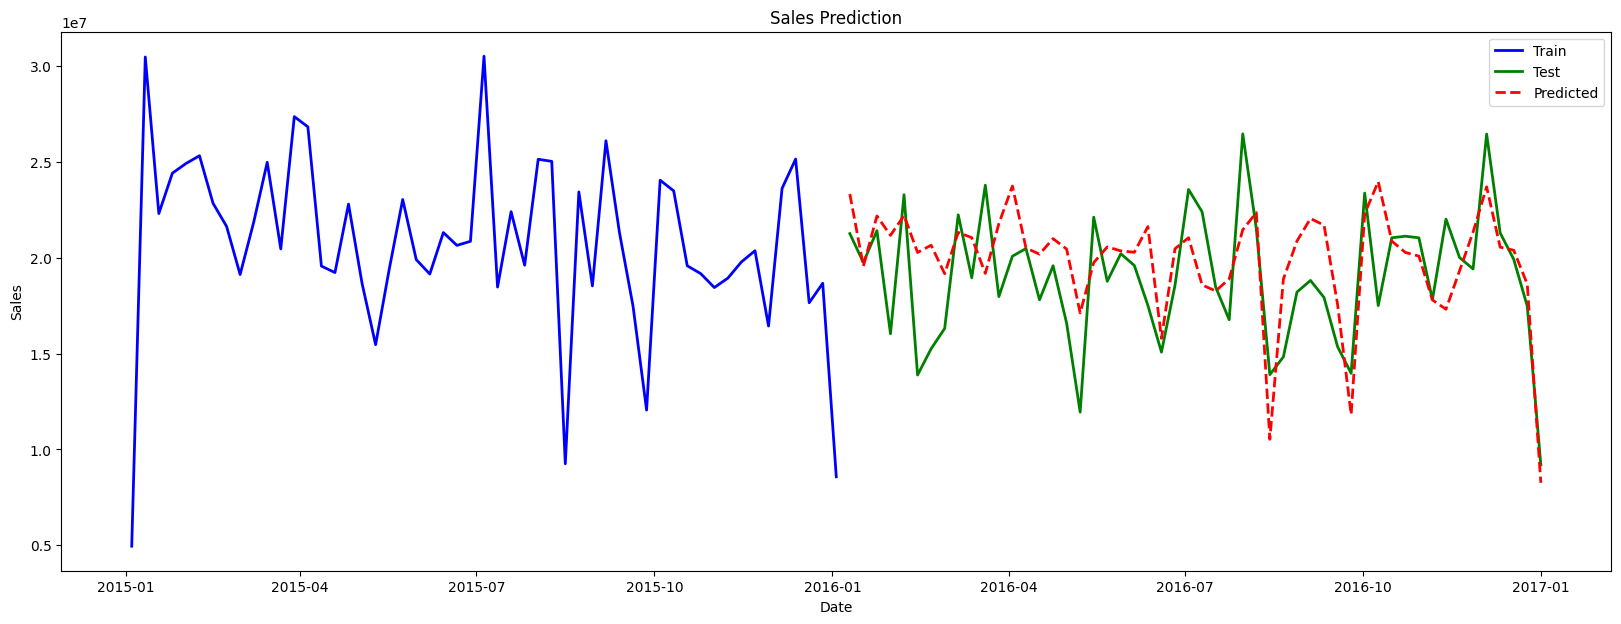

In [ ]:
mse_xgb = metrics.mean_squared_error(Y_test_w_inv, scaler.inverse_transform(pred_xgb.reshape(-1, 1)))
print("MSE for XGBoost:", math.sqrt(mse_xgb))
r2_xgb =  metrics.r2_score(Y_test_w_inv, scaler.inverse_transform(pred_xgb.reshape(-1, 1)))
print("R2 for XGBoost:", r2_xgb )
mape_xgb =  metrics.mean_absolute_percentage_error(Y_test_w_inv, scaler.inverse_transform(pred_xgb.reshape(-1, 1)))
print("MAPE for XGBoost:", mape_xgb )

graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(pred_xgb.reshape(-1, 1)))

###2.7. Creando modelo 7: Modelo de suavizado exponencial multiplicativo

In [ ]:
%%time
from statsmodels.tsa.api import ExponentialSmoothing

#modelo de suavizado de datos
#model_suavizado_exponencial_multiplicativo = ExponentialSmoothing(Y_train_w_inv_tot, seasonal='mul', seasonal_periods=52, freq="W").fit()
model_suavizado_exponencial_multiplicativo = ExponentialSmoothing(Y_train_w_inv_tot, trend='mul', seasonal='mul', seasonal_periods=52, freq="W").fit()
#se ejecuta el modelo, suavizando los datos
pred_suavizado_exponencial_multiplicativo = model_suavizado_exponencial_multiplicativo.predict(start=1, end=52)

CPU times: user 528 ms, sys: 34 ms, total: 562 ms
Wall time: 851 ms


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MSE for suavizado exponencial multiplicativo: 2880718.3583674785
R2 for suavizado exponencial multiplicativo: 0.28068646196163194
MAPE for suavizado exponencial multiplicativo: 0.1346474597251549


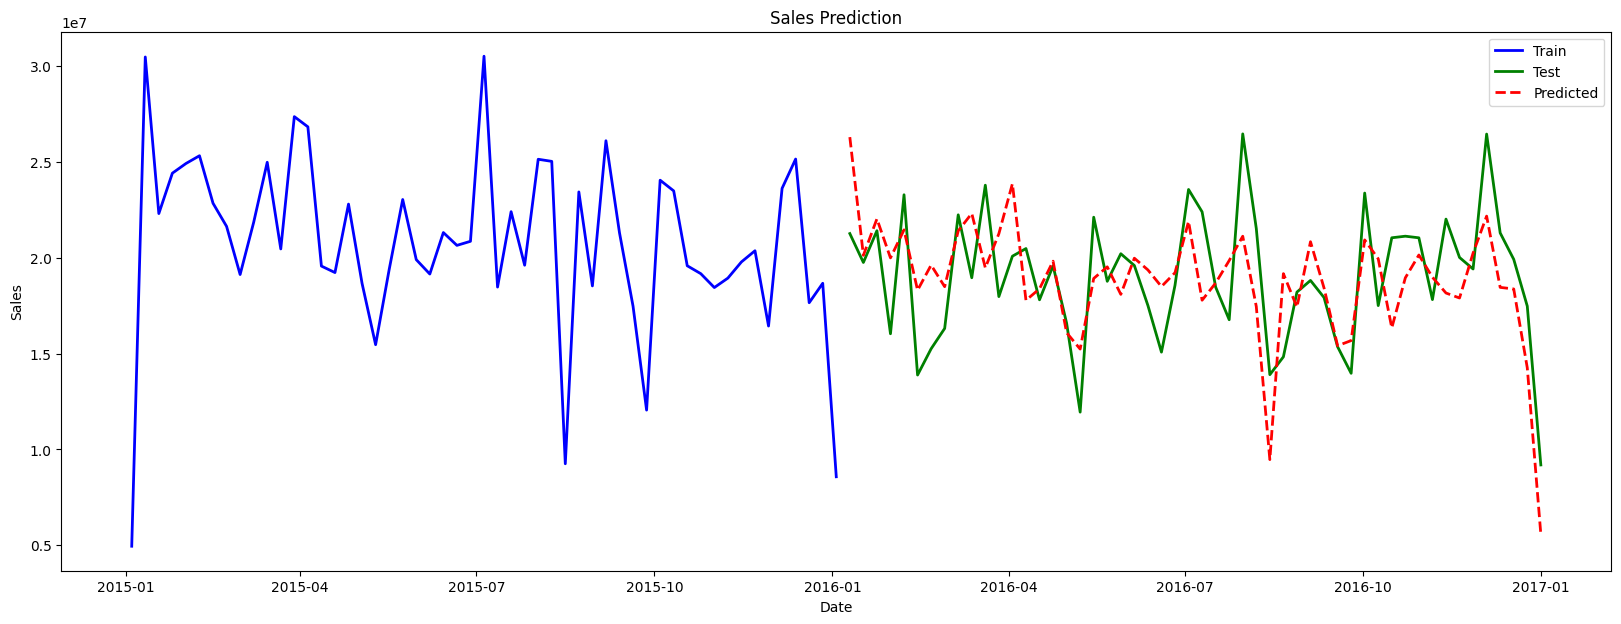

In [ ]:
mse_suavizado_exponencial_multiplicativo = metrics.mean_squared_error(Y_test_w_inv, pred_suavizado_exponencial_multiplicativo)
print("MSE for suavizado exponencial multiplicativo:", math.sqrt(mse_suavizado_exponencial_multiplicativo))

r2_suavizado_exponencial_multiplicativo =  metrics.r2_score(Y_test_w_inv, pred_suavizado_exponencial_multiplicativo)
print("R2 for suavizado exponencial multiplicativo:", r2_suavizado_exponencial_multiplicativo)

mape_suavizado_exponencial_multiplicativo =  metrics.mean_absolute_percentage_error(Y_test_w_inv, pred_suavizado_exponencial_multiplicativo)
print("MAPE for suavizado exponencial multiplicativo:", mape_suavizado_exponencial_multiplicativo)

graph(Y_train_w_inv[52*2:],Y_test_w_inv,pred_suavizado_exponencial_multiplicativo)

###2.8. Creando modelo 8: Red neuronal recurrente

####2.8.1 RNN con 1 lag

In [ ]:
tf.random.set_seed(12345)

In [ ]:
ts_scaled_train = data_weekly_scaled[:-52]
ts_scaled_test  = data_weekly_scaled[-52:]

$\color{blue}{\to}$ Ajustando la forma de los datos (`batch_size`, `duración de series temporales`, `n_input`)


In [ ]:
ts_scaled_2 = ts_scaled_train.reshape(1, -1, 1)

ts_scaled_2.shape

(1, 209, 1)

$\color{blue}{\to}$ Hiperparámetros

In [ ]:
n_epochs = 1000
batch_size = 1  # solo hay una serie de tiempo, entonces no hay otra opción que 1
learn_rate = 0.0002

In [ ]:
n_input = 1      # entrada escalar
n_neurons = 100  # cantidad de neuronas por capa
n_output = 1     # salida escalar

$\color{blue}{\text{|}}$ Red RNN

In [ ]:
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, None, 100)           │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, None, 1)             │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Define el optimizador y compila
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss="mse", optimizer=my_optimizer, metrics=["mse", "mape"])

In [ ]:
%%time
## Entrena el modelo: 1min 10s
my_summary = my_model.fit(ts_scaled_2[:, :-1, :], ts_scaled_2[:, 1:, :], epochs=n_epochs,
                          batch_size=batch_size, verbose=1)

#ten en cuenta que y es X corrido en +1

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - loss: 0.7425 - mape: 1604452.2500 - mse: 0.7425
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.5381 - mape: 912443.2500 - mse: 0.5381
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.3649 - mape: 196841.8281 - mse: 0.3649
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2279 - mape: 524065.4375 - mse: 0.2279
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1300 - mape: 1224125.0000 - mse: 0.1300
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0702 - mape: 1880725.7500 - mse: 0.0702
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0429 - mape: 2476515.0000 - mse: 0.0429
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0404 - mape: 2995027.2500 - mse: 0.0404
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0528 - mape: 3416880.7500 - mse: 0.0528
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0699 - mape: 3725127.5000 - mse:

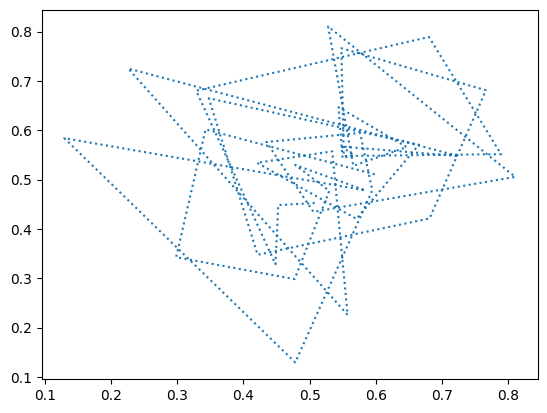

In [ ]:
# ts_scaled_2[:, 1:, :][0][0:40]
plt.plot(ts_scaled_2[:, :-1, :][0][0:40], ts_scaled_2[:, 1:, :][0][0:40],  linestyle="dotted");


In [ ]:
my_summary.history.keys()

dict_keys(['loss', 'mape', 'mse'])

Graficando el historial de entrenamiento

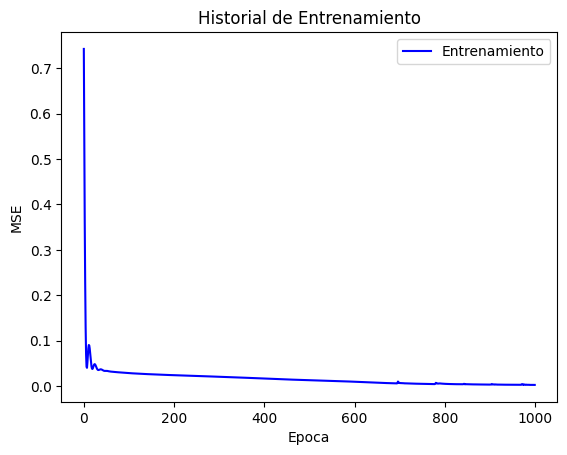

In [ ]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Historial de Entrenamiento')
plt.ylabel('MSE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

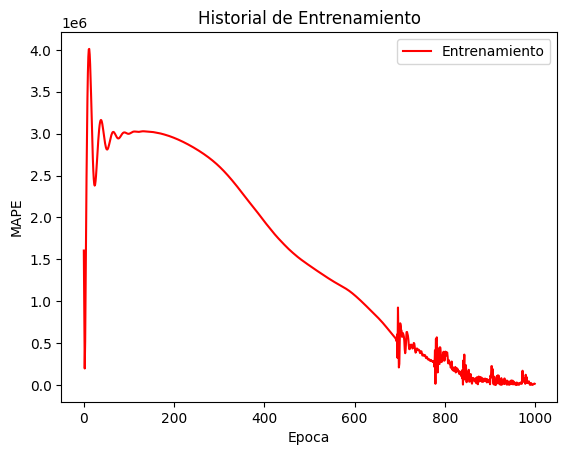

In [ ]:
plt.plot(my_summary.history['mape'], c="r")
plt.title('Historial de Entrenamiento')
plt.ylabel('MAPE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

Predicciones del futuro

In [ ]:
n_ts_seed = 12             # tamaño de la semilla
n_predict_time_steps = 52 # tamaño de la predicción

ts_seed = ts_scaled_train[:]
for i in range(n_predict_time_steps):
  X = ts_seed.reshape(1, -1, 1)
  y_pred = my_model.predict(X, verbose=1)
  y_last = y_pred[0, -1, 0]
  ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1, 1)), axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Transformación inversa y muestra las series temporales

MSE for RNN: 4169667.7309885724
R2 for RNN: -0.5070217865050664
MAPE for RNN: 0.19516024512949792


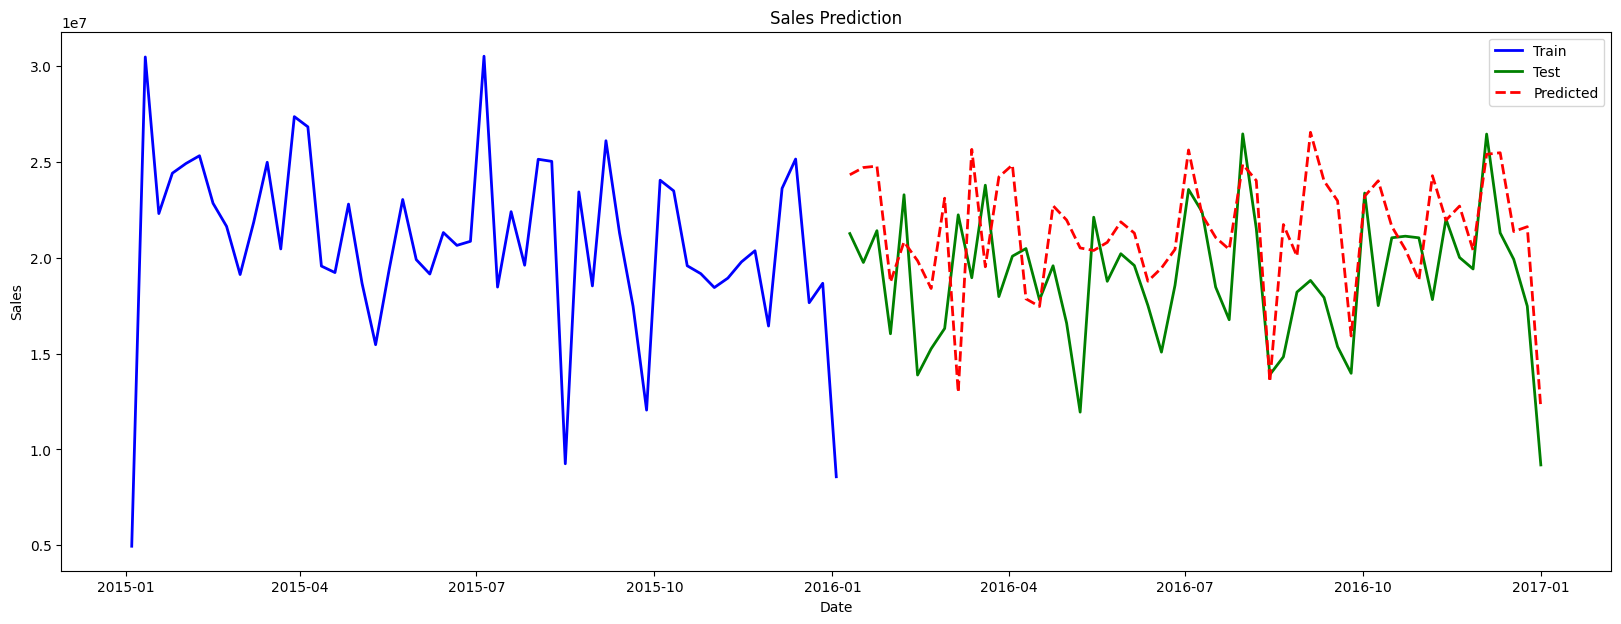

In [ ]:
mse_RNN = metrics.mean_squared_error(scaler.inverse_transform(ts_scaled_test), scaler.inverse_transform(ts_seed)[-52:])
print("MSE for RNN:", math.sqrt(mse_RNN))

r2_RNN =  metrics.r2_score(scaler.inverse_transform(ts_scaled_test), scaler.inverse_transform(ts_seed)[-52:])
print("R2 for RNN:", r2_RNN)

mape_RNN =  metrics.mean_absolute_percentage_error(scaler.inverse_transform(ts_scaled_test), scaler.inverse_transform(ts_seed)[-52:])
print("MAPE for RNN:", mape_RNN)

graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(ts_seed)[-52:])

####2.8.2 RNN con 12 lags

In [ ]:
#X_train_w
#Y_train_w

#X_test_w
#Y_test_w

$\color{blue}{\to}$ Ajustando la forma de los datos (`batch_size`, `duración de series temporales`, `n_input`)


In [ ]:
ts_scaled_2_train_X = X_train_w.to_numpy().reshape(-1, 52, 1)
ts_scaled_2_train_Y = Y_train_w.to_numpy().reshape(-1, 1, 1)

ts_scaled_2_test_X = X_test_w.to_numpy().reshape(-1, 52, 1)
ts_scaled_2_test_Y = Y_test_w.to_numpy().reshape(-1, 1, 1)

print(ts_scaled_2_train_X.shape)
print(ts_scaled_2_train_Y.shape)

print(ts_scaled_2_test_X.shape)
print(ts_scaled_2_test_Y.shape)

(157, 52, 1)
(157, 1, 1)
(52, 52, 1)
(52, 1, 1)


$\color{blue}{\to}$ Hiperparámetros

In [ ]:
n_epochs_2 = 200
batch_size_2 = 4  # solo hay una serie de tiempo, entonces no hay otra opción que 1
learn_rate_2 = 0.0002

In [ ]:
n_input_2 = 52      # entrada escalar
n_neurons_2 = 200  # cantidad de neuronas por capa
n_output_2 = 1     # salida escalar

$\color{blue}{\text{|}}$ Red RNN

In [ ]:
my_model_2 = Sequential()
my_model_2.add(SimpleRNN(units=n_neurons_2, return_sequences=True, input_shape=(n_input_2, 1)))
#my_model_2.add(TimeDistributed(Dense(units=n_output_2, activation="linear")))
my_model_2.add(Flatten())
my_model_2.add(Dense(n_output_2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
my_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 52, 200)             │          40,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          10,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,801 (198.44 KB)

 Trainable params: 50,801 (198.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Define el optimizador y compila
my_optimizer_2=Adam(learning_rate=learn_rate_2)
my_model_2.compile(loss="mse", optimizer=my_optimizer_2, metrics=["mse", "mape"])

In [ ]:
%%time
## Entrena el modelo: 1min 10s
my_summary_2 = my_model_2.fit(ts_scaled_2_train_X, ts_scaled_2_train_Y, epochs=n_epochs_2,
                          batch_size=batch_size_2, verbose=1)

#ten en cuenta que y es X corrido en +1

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1467 - mape: 2444554.0000 - mse: 0.1467
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0413 - mape: 1892684.1250 - mse: 0.0413 
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0293 - mape: 1752292.1250 - mse: 0.0293
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0289 - mape: 1775003.3750 - mse: 0.0289
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - mape: 1829518.7500 - mse: 0.0278
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0274 - mape: 1924200.5000 - mse: 0.0274
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0265 - mape: 2045832.5000 - mse: 0.0265
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0250 - mape: 2127254.0000 - mse: 0.0250
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0244 - mape: 2269224.5000 - mse: 0.0244
Epoch 10/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0228 - mape: 2293559.

Graficando el historial de entrenamiento

In [ ]:
display(my_summary_2.history.keys())

dict_keys(['loss', 'mape', 'mse'])

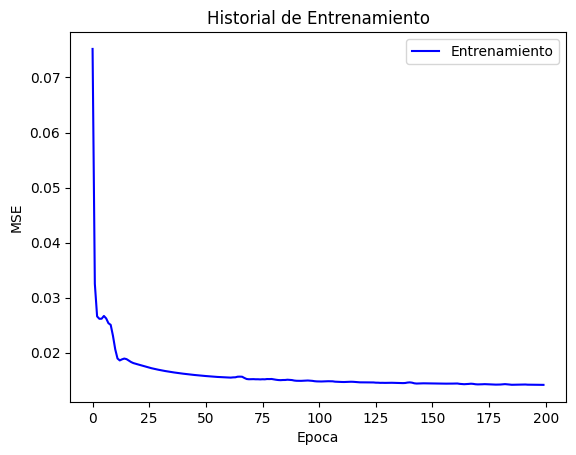

In [ ]:
plt.plot(my_summary_2.history['mse'], c="b")
plt.title('Historial de Entrenamiento')
plt.ylabel('MSE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

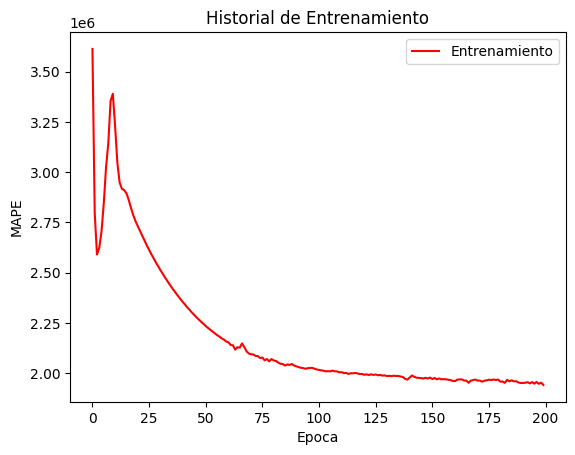

In [ ]:
plt.plot(my_summary_2.history['mape'], c="r")
plt.title('Historial de Entrenamiento')
plt.ylabel('MAPE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

Prediciedo el futuro

In [ ]:
predictions = my_model_2.predict(ts_scaled_2_test_X)
print(predictions.shape)
print(ts_scaled_2_test_Y.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
(52, 1)
(52, 1, 1)


Transformación inversa y muestra las series temporales

MSE for RNN: 3395583.378311376
R2 for RNN: 0.0005859938572903012
MAPE for RNN: 0.14952129686441606


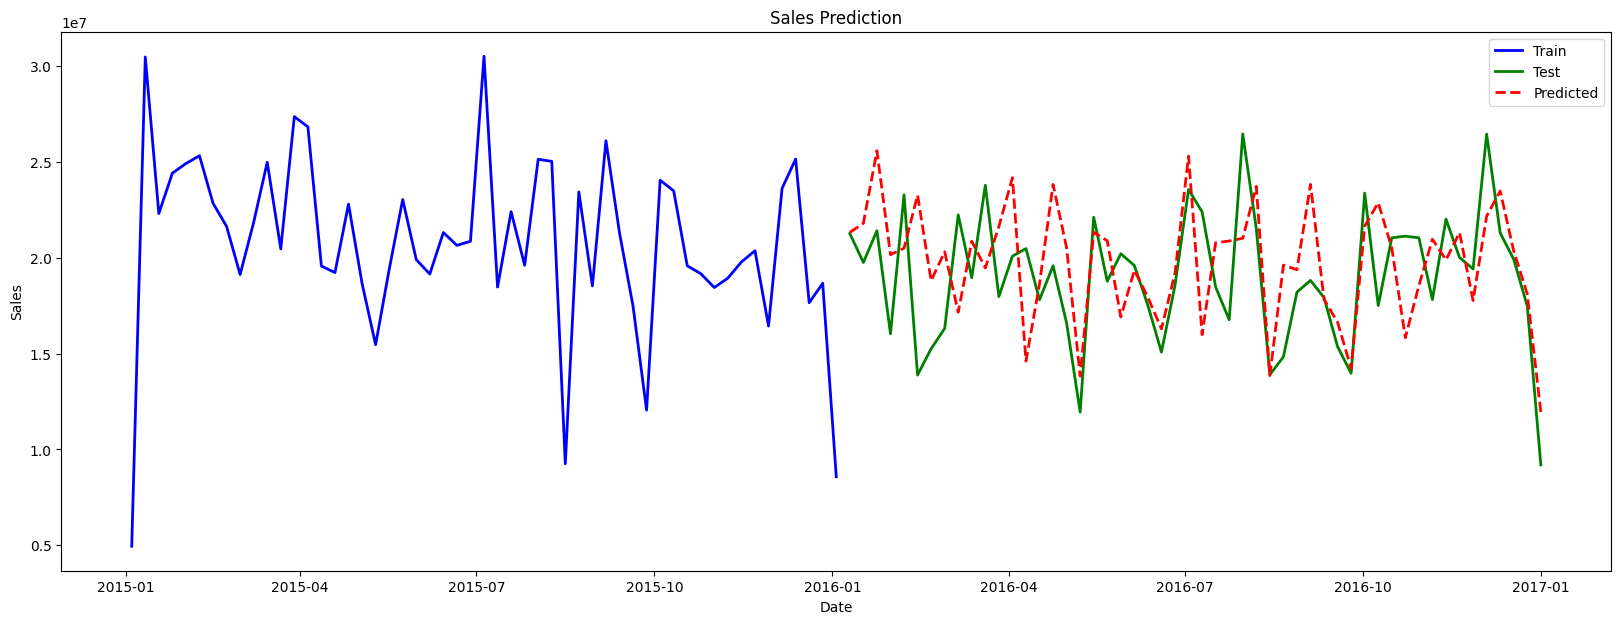

In [ ]:
mse_RNN = metrics.mean_squared_error(scaler.inverse_transform(ts_scaled_2_test_Y.reshape(52,1)), scaler.inverse_transform(predictions))
print("MSE for RNN:", math.sqrt(mse_RNN))

r2_RNN =  metrics.r2_score(scaler.inverse_transform(ts_scaled_2_test_Y.reshape(52,1)), scaler.inverse_transform(predictions))
print("R2 for RNN:", r2_RNN)

mape_RNN =  metrics.mean_absolute_percentage_error(scaler.inverse_transform(ts_scaled_2_test_Y.reshape(52,1)), scaler.inverse_transform(predictions))
print("MAPE for RNN:", mape_RNN)

graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(predictions))

###2.9. Creando modelo 9: Red LSTM

####2.9.1 LSTM con 1 lag

In [ ]:
ts_scaled_train = data_weekly_scaled[:-52]
ts_scaled_test  = data_weekly_scaled[-52:]

$\color{blue}{\to}$ Ajustando la forma de los datos (`batch_size`, `duración de series temporales`, `n_input`)


In [ ]:
ts_scaled_2 = ts_scaled_train.reshape(1, -1, 1)

ts_scaled_2.shape

(1, 209, 1)

$\color{blue}{\to}$ Hiperparámetros

In [ ]:
n_epochs = 500
batch_size = 1  # solo hay una serie de tiempo, entonces no hay otra opción que 1
learn_rate = 0.0002

In [ ]:
n_input = 1      # entrada escalar
n_neurons = 500  # cantidad de neuronas por capa
n_output = 1     # salida escalar

$\color{blue}{\text{|}}$ Red LSTM

In [ ]:
my_model = Sequential()
my_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))
#my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))
my_model.add(Dense(n_output))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 500)           │       1,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 1)             │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,004,501 (3.83 MB)

 Trainable params: 1,004,501 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Define el optimizador y compila
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss="mse", optimizer=my_optimizer, metrics=["mse", "mape"])

In [ ]:
%%time
## Entrena el modelo: 1min 10s
my_summary = my_model.fit(ts_scaled_2[:, :-1, :], ts_scaled_2[:, 1:, :], epochs=n_epochs,
                          batch_size=batch_size, verbose=1)

#ten en cuenta que y es X corrido en +1

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3136 - mape: 219843.0312 - mse: 0.3136
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2546 - mape: 546847.5625 - mse: 0.2546
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2014 - mape: 880965.3750 - mse: 0.2014
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1532 - mape: 1231216.7500 - mse: 0.1532
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1100 - mape: 1608789.3750 - mse: 0.1100
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0728 - mape: 2029079.7500 - mse: 0.0728
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0443 - mape: 2513441.0000 - mse: 0.0443
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0310 - mape: 3086717.7500 - mse: 0.0310
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0424 - mape: 3721295.7500 - mse: 0.0424
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0603 - mape: 4076757.0000 - mse: 0.0603
Epoc

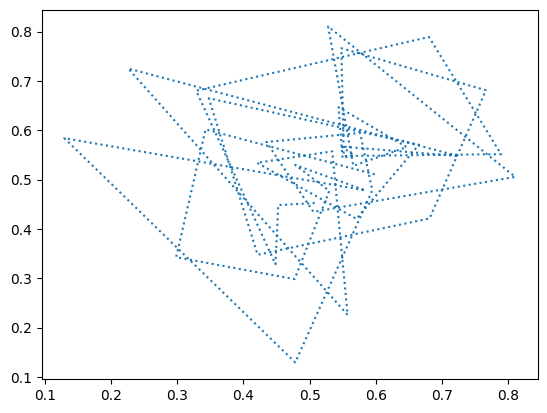

In [ ]:
# ts_scaled_2[:, 1:, :][0][0:40]
plt.plot(ts_scaled_2[:, :-1, :][0][0:40], ts_scaled_2[:, 1:, :][0][0:40],  linestyle="dotted");


In [ ]:
my_summary.history.keys()

dict_keys(['loss', 'mape', 'mse'])

Graficando el historial de entrenamiento

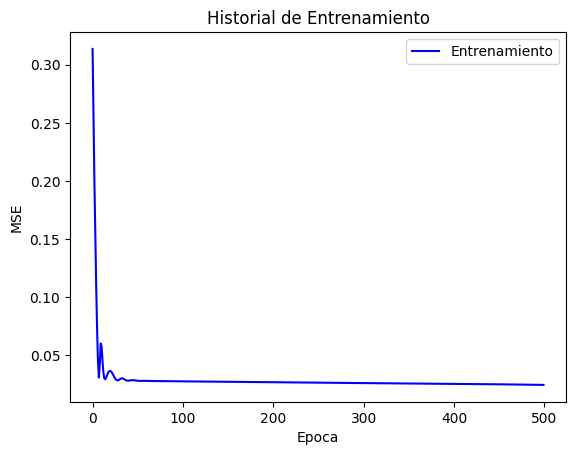

In [ ]:
plt.plot(my_summary.history['mse'], c="b")
plt.title('Historial de Entrenamiento')
plt.ylabel('MSE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

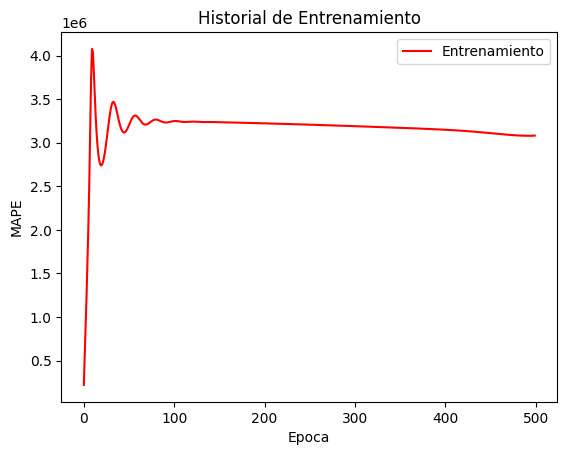

In [ ]:
plt.plot(my_summary.history['mape'], c="r")
plt.title('Historial de Entrenamiento')
plt.ylabel('MAPE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

Predicción del futuro

In [ ]:
n_ts_seed = 12             # tamaño de la semilla
n_predict_time_steps = 52 # tamaño de la predicción

ts_seed = ts_scaled_train[:]
for i in range(n_predict_time_steps):
  X = ts_seed.reshape(1, -1, 1)
  y_pred = my_model.predict(X, verbose=1)
  y_last = y_pred[0, -1, 0]
  ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1, 1)), axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

Transformación inversa y muestra las series temporales

MSE for suavizado exponencial multiplicativo: 3523842.87295648


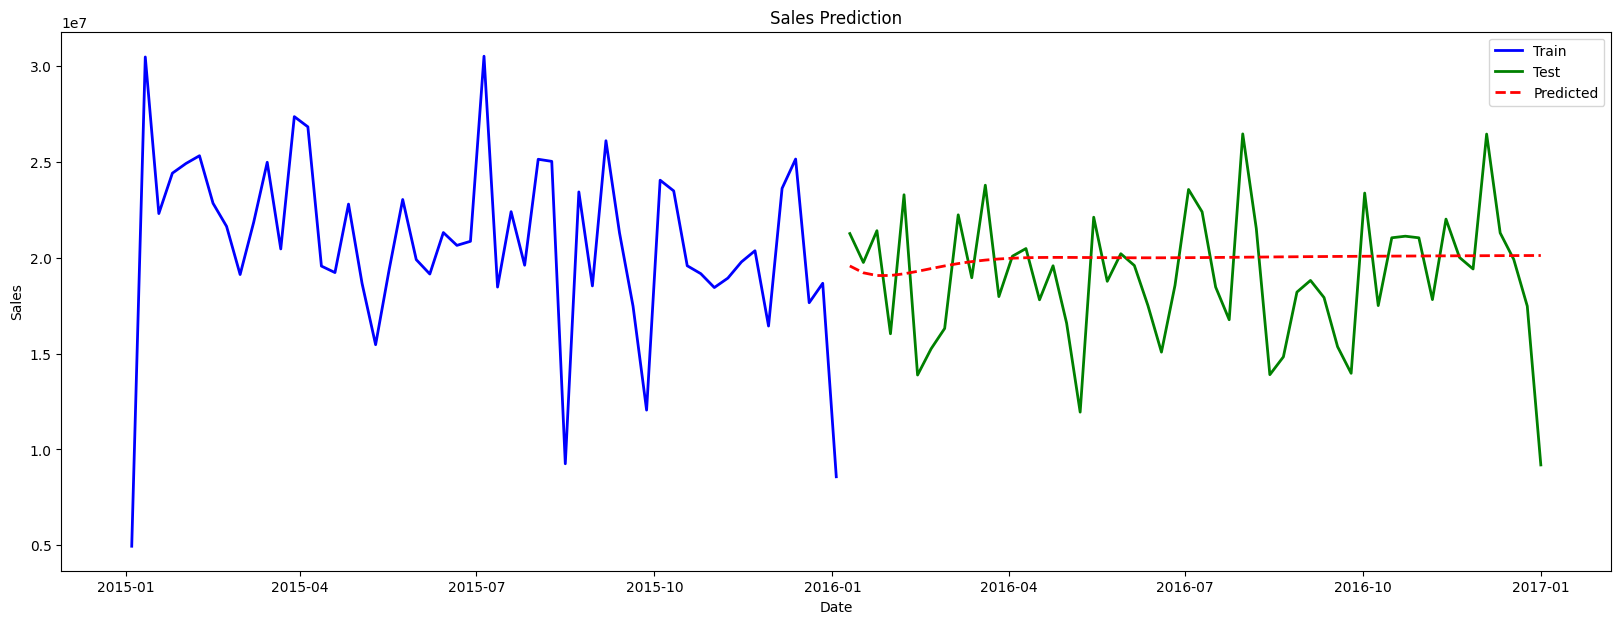

In [ ]:
mse_RNN = metrics.mean_squared_error(scaler.inverse_transform(ts_scaled_test), scaler.inverse_transform(ts_seed)[-52:])
print("MSE for suavizado exponencial multiplicativo:", math.sqrt(mse_RNN))
graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(ts_seed)[-52:])

####2.8.2 LSTM con 12 lags

In [ ]:
#X_train_w
#Y_train_w

#X_test_w
#Y_test_w

$\color{blue}{\to}$ Ajustando la forma de los datos (`batch_size`, `duración de series temporales`, `n_input`)


$\color{blue}{\to}$ Hiperparámetros

In [ ]:
n_epochs_3 = 300
batch_size_3 = 12  # solo hay una serie de tiempo, entonces no hay otra opción que 1
learn_rate_3 = 0.00015

In [ ]:
n_input_3 = 52      # entrada escalar
n_neurons_3 = 200  # cantidad de neuronas por capa
n_output_3 = 1     # salida escalar

$\color{blue}{\text{|}}$ Red LSTM

In [ ]:
my_model_3 = Sequential()
my_model_3.add(LSTM(units=n_neurons_3, return_sequences=True, input_shape=(n_input_3, 1)))
#my_model_3.add(TimeDistributed(Dense(units=n_output_2, activation="linear")))
my_model_3.add(Dropout(0.3))
my_model_3.add(Flatten())
my_model_3.add(Dense(n_output_3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
my_model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 52, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 52, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          10,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,001 (671.88 KB)

 Trainable params: 172,001 (671.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Define el optimizador y compila
my_optimizer_3=Adam(learning_rate=learn_rate_3)
my_model_3.compile(loss="mse", optimizer=my_optimizer_3, metrics=["mse", "mape"])

In [ ]:
%%time
## Entrena el modelo: 1min 10s
my_summary_3 = my_model_3.fit(ts_scaled_2_train_X, ts_scaled_2_train_Y, epochs=n_epochs_3,
                          batch_size=batch_size_3, verbose=1)


Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2323 - mape: 1913255.8750 - mse: 0.2323
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0259 - mape: 3237686.5000 - mse: 0.0259
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0293 - mape: 2793471.7500 - mse: 0.0293
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0245 - mape: 3172239.5000 - mse: 0.0245
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0236 - mape: 3215042.7500 - mse: 0.0236
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0260 - mape: 3289140.7500 - mse: 0.0260
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0240 - mape: 2977267.5000 - mse: 0.0240
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244 - mape: 3015250.0000 - mse: 0.0244
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0256 - mape: 2919191.5000 - mse: 0.0256
Epoch 10/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - mape: 3367196.250

Graficando el historial de entrenamiento

In [ ]:
display(my_summary_3.history.keys())

dict_keys(['loss', 'mape', 'mse'])

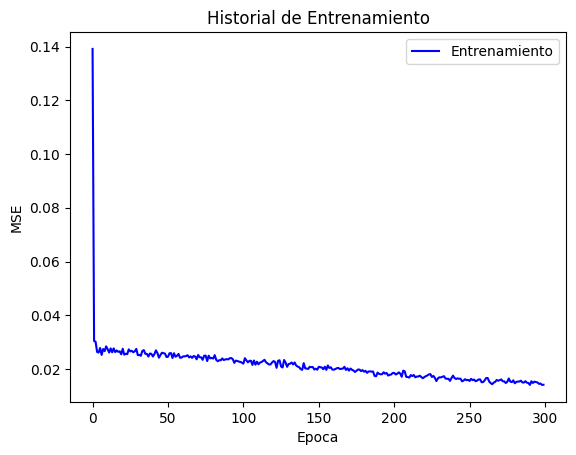

In [ ]:
plt.plot(my_summary_3.history['mse'], c="b")
plt.title('Historial de Entrenamiento')
plt.ylabel('MSE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

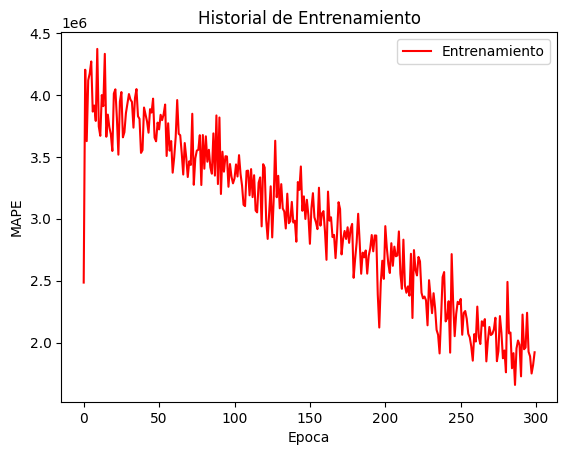

In [ ]:
plt.plot(my_summary_3.history['mape'], c="r")
plt.title('Historial de Entrenamiento')
plt.ylabel('MAPE')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()

Prediciedo el futuro

In [ ]:
ts_scaled_2_test_X.shape

(52, 52, 1)

In [ ]:
predictions_3 = my_model_3.predict(ts_scaled_2_test_X)
print(predictions_3.shape)
print(ts_scaled_2_test_Y.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(52, 1)
(52, 1, 1)


Transformación inversa y muestra las series temporales

MSE for LSTM: 3008813.2552047824
R2 for LSTM: 0.21529376952766144
MAPE for LSTM: 0.13240896785418196


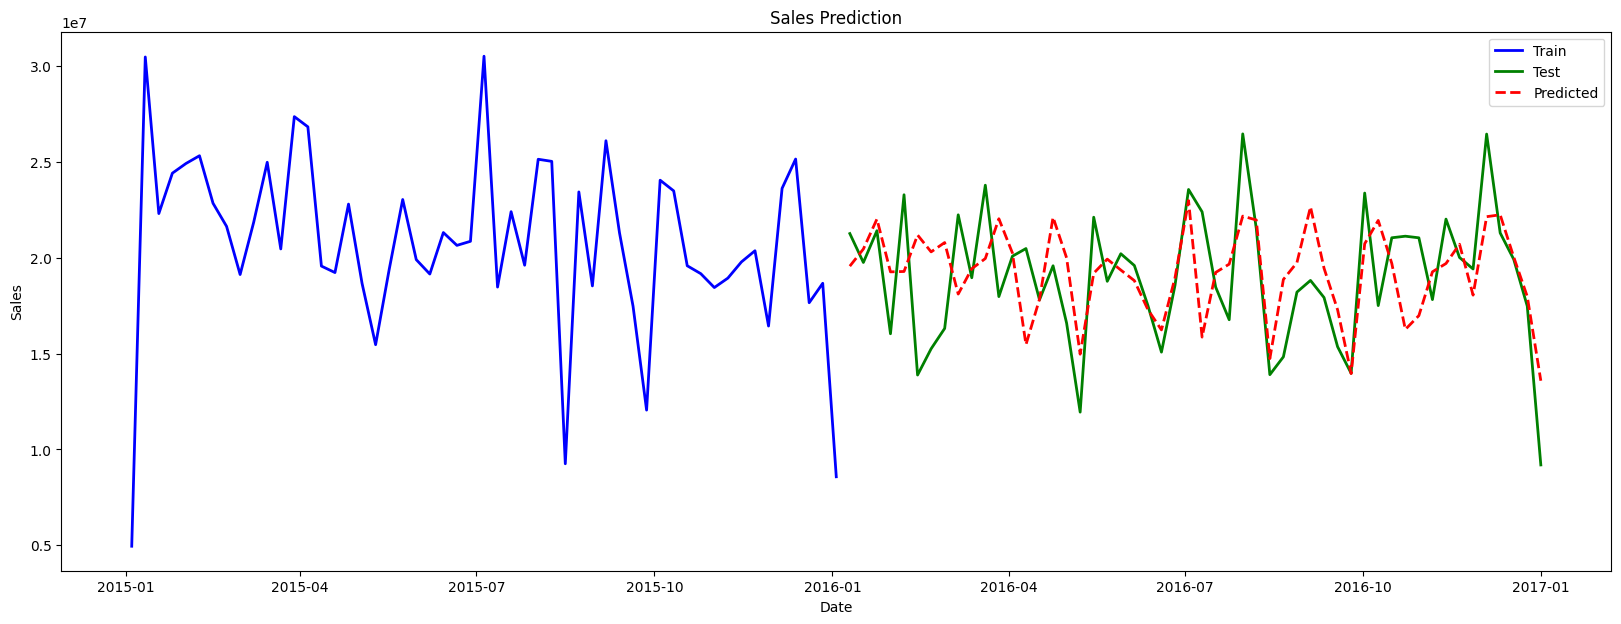

In [ ]:
mse_LSTM = metrics.mean_squared_error(scaler.inverse_transform(ts_scaled_2_test_Y.reshape(52,1)), scaler.inverse_transform(predictions_3))
print("MSE for LSTM:", math.sqrt(mse_LSTM))

r2_LSTM  =  metrics.r2_score(scaler.inverse_transform(ts_scaled_2_test_Y.reshape(52,1)), scaler.inverse_transform(predictions_3))
print("R2 for LSTM:", r2_LSTM )

mape_LSTM =  metrics.mean_absolute_percentage_error(scaler.inverse_transform(ts_scaled_2_test_Y.reshape(52,1)), scaler.inverse_transform(predictions_3))
print("MAPE for LSTM:", mape_LSTM )

graph(Y_train_w_inv[52*2:],Y_test_w_inv,scaler.inverse_transform(predictions_3))

# **Top de modelos según métricas de desempeño**

In [ ]:
print("1. MSE for suavizado exponencial multiplicativo:", math.sqrt(mse_suavizado_exponencial_multiplicativo)," - R2 for suavizado exponencial multiplicativo:", r2_suavizado_exponencial_multiplicativo, " - MAPE for suavizado exponencial multiplicativo:", mape_suavizado_exponencial_multiplicativo)
print("2. MSE for XGBoost:", math.sqrt(mse_xgb)," - R2 for XGBoost:", r2_xgb , "- MAPE for XGBoost:", mape_xgb )
print("3. MSE for LSTM:", math.sqrt(mse_LSTM)," - R2 for LSTM:", r2_LSTM , "- MAPE for LSTM:", mape_LSTM )
print("4. MSE for Random Forest:", math.sqrt(mse_rf)," - R2 for Random Forest:", r2_rf ,"- MAPE for Random Forest:", mape_rf )
print("5. MSE for AdaBoost:", math.sqrt(mse_ab)," - R2 for AdaBoost:", r2_ab ,"- MAPE for AdaBoost:", mape_ab )
print("6. MSE for SVM:", math.sqrt(mse_svm)," - R2 for SVM:", r2_svm ,"- MAPE for SVM:", mape_svm )
print("7. MSE for KNN:", math.sqrt(mse_knn)," - R2 for KNN:", r2_knn,"- MAPE for KNN:", mape_knn )
print("8. MSE for Decision Tree:", math.sqrt(mse_dt)," - R2 for Decision Tree:", r2_dt, "- MAPE for Decision Tree:", mape_dt )
print("9. MSE for RNN:", math.sqrt(mse_RNN)," - R2 for RNN:", r2_RNN, "- MAPE for RNN:", mape_RNN )

1. MSE for suavizado exponencial multiplicativo: 2880718.3583674785  - R2 for suavizado exponencial multiplicativo: 0.28068646196163194  - MAPE for suavizado exponencial multiplicativo: 0.1346474597251549
2. MSE for XGBoost: 2929590.898964269  - R2 for XGBoost: 0.256072541201405 - MAPE for XGBoost: 0.13295649155470046
3. MSE for LSTM: 3008813.2552047824  - R2 for LSTM: 0.21529376952766144 - MAPE for LSTM: 0.13240896785418196
4. MSE for Random Forest: 2967610.1281195316  - R2 for Random Forest: 0.23663837675692456 - MAPE for Random Forest: 0.13843138256446347
5. MSE for AdaBoost: 3051786.05261265  - R2 for AdaBoost: 0.19271886972821384 - MAPE for AdaBoost: 0.14614527402698405
6. MSE for SVM: 3068109.1481214794  - R2 for SVM: 0.18405996142688397 - MAPE for SVM: 0.14906750199241697
7. MSE for KNN: 3127955.2321376977  - R2 for KNN: 0.15191830214128643 - MAPE for KNN: 0.15068627218385094
8. MSE for Decision Tree: 3329049.3140242547  - R2 for Decision Tree: 0.03936790925442568 - MAPE for Dec

| TOP | MODELO | MSE | R2 | MAPE | TIEMPO EJECUCION |
|------------|------------|------------|------------|------------|------------|
| 1     | Suavizado Exponencial Multiplicativo     | 2880718.358    | 0.280686     | 0.13464745 | 965ms |
| 2     | XGBoost     | 2929590.8989    | 0.256072     | 0.132956 | 1min 29s |
| 3     | LSTM     |  3008813.255    | 0.2152937     | 0.1324089 | 50.2s |
| 4     | Random Forest     | 2967610.128    | 0.236638     | 0.13843138 | 32.4s |
| 5     | AdaBoots     |3051786.052    | 0.192718    | 0.146145 | 8.27s |
| 6     | SVM     | 3068109.1481   | 0.184059     | 0.149067 | 671ms |
| 7     | KNN     | 3127955.232    | 0.151918    | 0.1506862 | 2.54s |
| 8     | Decision Tree     | 3329049.314    | 0.0393679     | 0.0393679 | 10.2 s |
| 9     | RNN     | 3523842.872    | 0.00058599     | 0.149521 | 1min 46s |




---



# **Conclusiones**

1-) El uso de LAGs para el entrenamiento de algoritmos de machine learning en forecasting fue muy necesario, ya que así pudimos utilizar algoritmos de ML de regresión para este proyecto. Además, mejoraron el desempeño de predicción en las redes neuronales RNN y LSTM.

2-) En los resultados de este proyecto, se pudo observar que el modelo con las mejores predicciones y rendimiento fue el Exponential Smothing con un RMSE suavizado exponencial multiplicativo de 2880718.3583674785  y un R2 suavizado exponencial multiplicativo de 0.28068646196163194 y un MAPE suavizado exponencial multiplicativo de 13,46%.



---



# 🚀**Despliegue del modelo** (etapa 4)

#### El mejor modelo fue **Suavizado Exponencial Multiplicativo**


In [ ]:
## Generacion del mejor modelo en formato PKL

import pickle

# Guardar el modelo usando Pickle
model_suavizado_exponencial_multiplicativo = ExponentialSmoothing(Y_train_w_inv_tot, trend='mul', seasonal='mul', seasonal_periods=52, freq="W").fit()
with open('BEST_MODEL_suavizado_exponencial_multiplicativo.pkl', 'wb') as file:
    pickle.dump(model_suavizado_exponencial_multiplicativo, file)

## Probar PKL
model_suavizado_exponencial_multiplicativo = ExponentialSmoothing(Y_train_w_inv_tot, trend='mul', seasonal='mul', seasonal_periods=52, freq="W").fit()
model_suavizado_exponencial_multiplicativo_Pickle = open('BEST_MODEL_suavizado_exponencial_multiplicativo_file', 'wb')
pickle.dump(model_suavizado_exponencial_multiplicativo, model_suavizado_exponencial_multiplicativo_Pickle)

# close the file
model_suavizado_exponencial_multiplicativo_Pickle.close()
modelo_cargado = pickle.load(open('BEST_MODEL_suavizado_exponencial_multiplicativo_file', 'rb'))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
!npm install localtunnel


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


### Genera archivo app.py

In [ ]:
%%writefile app.py
import streamlit as st
import altair as alt
import pandas as pd
import streamlit as st

path="/content/sample_data/"
data = pd.read_csv(path+'train_data.csv')
#path="/content/drive/MyDrive/Proyecto/Grupo 5/"
#data = pd.read_csv(path+'datos/train_data.csv')


with st.sidebar:
        st.title("🚀Configuration")
        api_options = ("Exponential Smothing")
        selected_api = st.selectbox(
            label="Choose the model:",
            options=api_options,
        )
        st.markdown("---")


st.sidebar.info(
    "This application attempts to forecast manufacturing output over a one-year period. The best prediction was achieved using the Exponential smoothing model.")
st.sidebar.success("Select a model above.")
st.sidebar.markdown("---")
st.sidebar.markdown(
            '<h6>Made in &nbsp<img src="https://streamlit.io/images/brand/streamlit-mark-color.png" alt="logo" height="16">&nbsp by <a href="#">Juan Carlos | Sergio</a></h6>',
            unsafe_allow_html=True,
        )


#st.set_page_config(layout="centered", page_title=':signal_strength:Proyecto, *IA MINTIC* ')
st.title(":signal_strength: *Forecasting: demanda de productos empresa Manufacturera*")
st.write("🤖Proyecto IA MinTic 2024")


@st.cache_data
def get_data():
    ###
    #source = data.stocks()
    #source = source[source.date.gt("2004-01-01")]
    #print(source.info())
    source = data
    return source


source = get_data()
print(source)




def space(num_lines=1):
    """Agrega espacios en la Streamlit app."""
    for _ in range(num_lines):
        st.write("")

def get_chart(data):
    hover = alt.selection_single(
        #fields=["date"],
        fields=["date"],
        nearest=True,
        on="mouseover",
        empty="none",
    )

    lines = (
        alt.Chart(data, title="FORECASTING: HISTORIAL DEMANDA DE PRODUCTOS ")
        .mark_line()
        .encode(
            # x="date",
            # y="price",
            # color="symbol",
            # strokeDash="symbol",
            x="date",
            y="sum",
            color="type",
            strokeDash="type",
        )
    )


    points = lines.transform_filter(hover).mark_circle(size=65)


    tooltips = (
        alt.Chart(data)
        .mark_rule()
        .encode(
            x="date",
            #y="price",
            y="sum",
            opacity=alt.condition(hover, alt.value(0.3), alt.value(0)),
            tooltip=[
                #alt.Tooltip("date", title="Date"),
                #alt.Tooltip("price", title="Price (USD)"),
                alt.Tooltip("date", title="Date"),
                alt.Tooltip("sum", title="Price (USD)"),
            ],
        )
        .add_selection(hover)
    )

    return (lines + points + tooltips).interactive()

space(1)

#all_symbols = source.symbol.unique()
all_symbols = source.type.unique()
symbols = st.multiselect("Choose item to visualize", all_symbols, all_symbols[:3])

space(2)



#source = source[source.symbol.isin(symbols)]
source = source[source.type.isin(symbols)]
chart = get_chart(source)
st.altair_chart(chart, use_container_width=True)

space(1)
# st.write("RESULTADOS:")
# st.write("MSE for suavizado exponencial multiplicativo: 2880718.3583674775")
# st.write("R2 for suavizado exponencial multiplicativo: 0.28068646196163227")
# st.write("MAPE for suavizado exponencial multiplicativo: 0.1346474597251549")

data = {
    'MODELO': ['Exponential Smothing'],
    'MSE': ['2880718.3583674775'],
    'R2': ['0.28068646196163227'],
    'MAPE': ['0.1346474597251549']
}
df_results = pd.DataFrame(data)

# Mostrar tabla
st.title('Resultados')
st.table(df_results)

space(1)


Writing app.py


In [ ]:
# Ejecutar st en background

!streamlit run app.py --server.address=localhost &>/content/logs.txt &

In [ ]:
import urllib
print("Password IP para localtunnel:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password IP para localtunnel: 34.82.110.192


### Abre la aplicación

In [ ]:
# Exponer puerto 8501, click en la URL

!npx localtunnel --port 8501

your url is: https://deep-socks-move.loca.lt


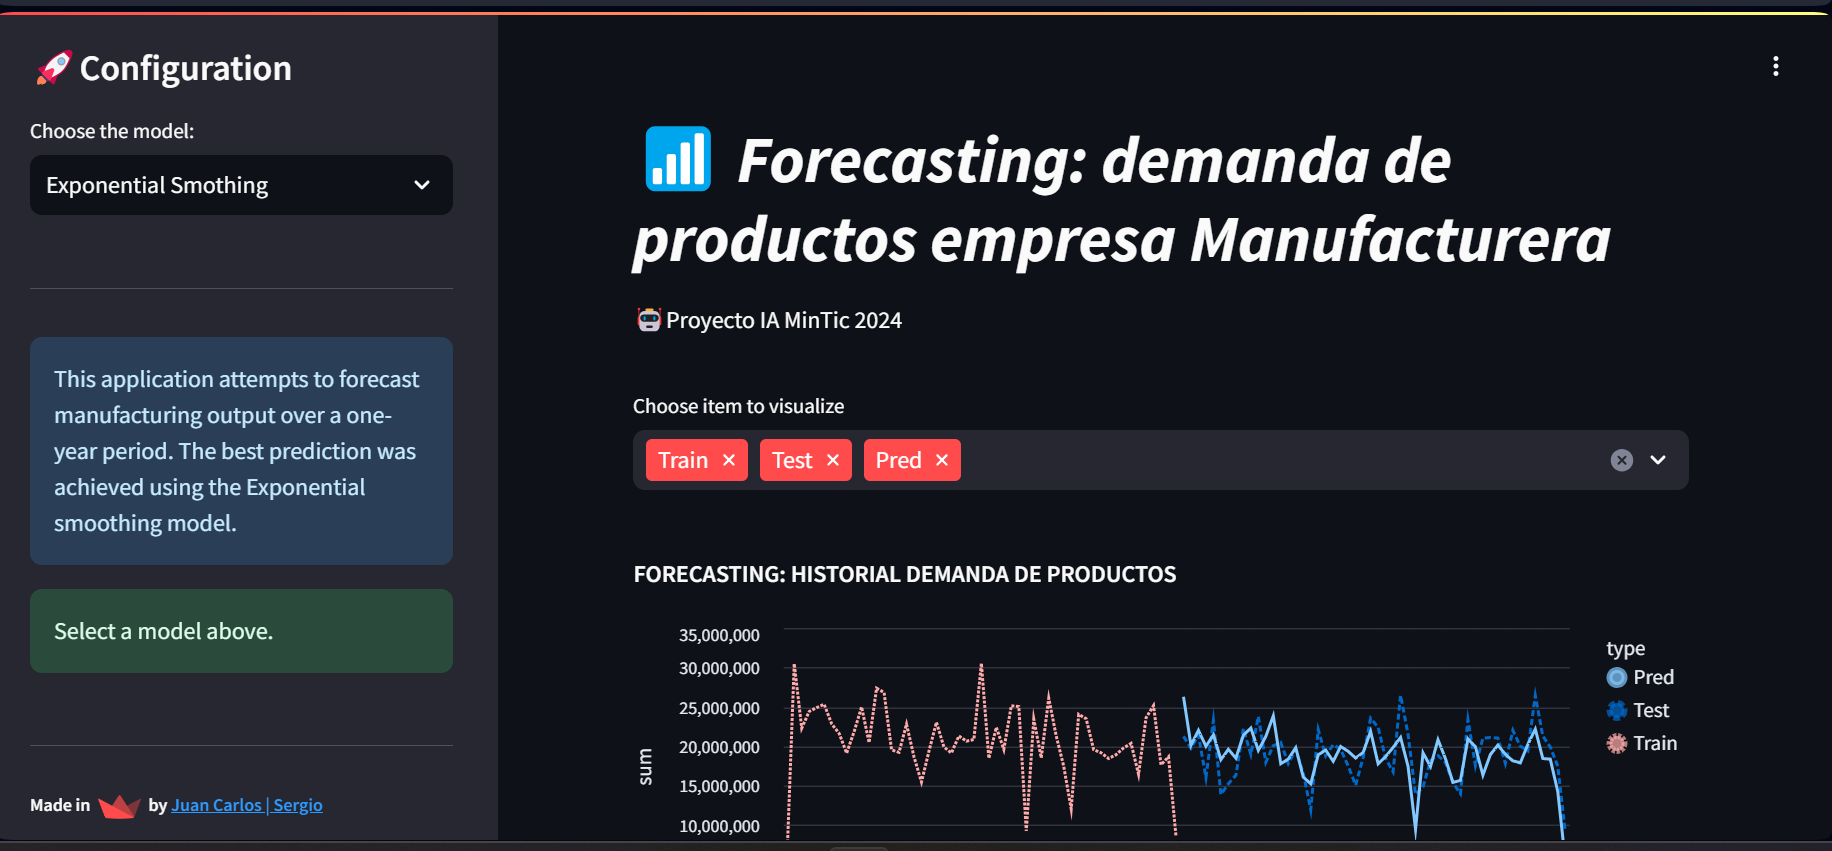

### ***¡GRACIAS!*** 👏